In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
def readImages():
    #open and conversion to original colours
    images = {}
    for i in range(num_models):
        img = cv2.imread(models_path+str(model_index[i])+models_estenstion);
        images[i] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
    
    #open and conversion to original colours
    scenes = {}
    for i in range(num_scenes):
        scenes[i] = cv2.imread(scene_path+scenes_names[i]+scenes_estenstion);
        scenes[i] = cv2.cvtColor(scenes[i],cv2.COLOR_BGR2RGB);
        
    grey_scenes = {}
    for i in range(num_scenes):
        grey_scenes[i] = cv2.imread(scene_path+scenes_names[i]+scenes_estenstion, 0);
        
    return images, scenes, grey_scenes

In [3]:
#MODEL IMAGES
model_index = {
    0: 0,
    1: 1,
    2: 11,
    3: 19,
    4: 24,
    5: 25,
    6: 26
}

model_texts = {
    0: "Nesquik",
    1: "CK Blue",
    11: "CK Orange",
    19: "Country Crisp",
    24: "Fitness",
    25: "Coco Pops",
    26: "Nesquik Duo",
}

models_estenstion = ".jpg"

models_path = "models/"

num_models = len(model_index);

#SCENES IMAGES
scenes_names = ["m2"]

scenes_estenstion = ".png"

scene_path = "scenes/"

num_scenes = len(scenes_names)

#MACRO VARIABLES
font = cv2.FONT_ITALIC
font_scale=1.0

# Checking if we found enough matching
MIN_MATCH_COUNT = 20
range_perimeter = (0.8,1.4)
LIMIT_INC = 55


In [4]:
def getFeatureMatcher():
    # Defining index for approximate kdtree algorithm
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    return flann

In [5]:
def getKeypoints(image):
    # find the keypoints and descriptors with SIFT
    kp_image = sift.detect(image)
    
    # Describing keypoints for image
    kp_image, des_image = sift.compute(image, kp_image)
    
    return kp_image, des_image

In [6]:
def computeBarycenter(kp_query):
    sum_x = 0
    sum_y = 0
    for i in range(len(kp_query)):
        sum_x = sum_x + kp_query[i].pt[0]
        sum_y = sum_y + kp_query[i].pt[1]
    bar = (int(sum_x/len(kp_query)), int(sum_y/len(kp_query)))
    return bar

In [7]:
def computeVectors(kp_models, barycenter):
    vectors = {}
    for i in range(len(kp_models)):
        vectors[i] = (barycenter[0] - kp_models[i].pt[0], barycenter[1] - kp_models[i].pt[1])
    return vectors

In [8]:
images, scenes, grey_scenes = readImages()

#get avarage colour of each model image
average_colors = {}

for i in range(num_models):
    #non considero il primo terzo dell'immagine che molte volte contiene il logo della marca
    start_row = int(images[i].shape[0]/3)
    #seleziono la parte dell'imagine da considerare
    selected_image = images[i][start_row: images[i].shape[0], :]
    #faccio la media
    average_color_row = np.average(selected_image, axis=0)
    average_colors[i] = np.average(average_color_row, axis=0).astype(int).tolist()

In [9]:
#Initiate SIFT detector
sift = cv2.SIFT_create()
flann = getFeatureMatcher()

kp_models = {}
des_models = {}
barycenters = {}
vectors = {}

for i in range(num_models):
    # Describing keypoints for model images
    kp_models[i], des_models[i] = getKeypoints(images[i])
    barycenters[i] = computeBarycenter(kp_models[i])
    vectors[i] = computeVectors(kp_models[i], barycenters[i])

fine baricentro


In [10]:
#plot matches
# white = np.zeros(scenes[0].shape)
# white.fill(255)

# good = []

# for m,n in matches:
#     if m.distance < 0.8*n.distance:
#         good.append(m)
#         #good.append(n)
        
# for p in good:
#     x = kp_train[p.trainIdx].pt[0]
#     white[(int(kp_train[p.trainIdx].pt[1])), int(kp_train[p.trainIdx].pt[0])] = 0
#     #print(x)

# plt.figure(figsize=(20, 10))
# plt.imshow(white, cmap='gray', vmin=0, vmax=255)
# plt.show()

In [11]:
def voting(imageShape, dst_points, vectors, ind_model):
    votes = []
    acc = np.zeros(imageShape)
    for j in range(len(dst_points)): 
        #dst_points[j][1] indice del kp_model associato al kp_train
        vec = vectors[dst_points[j][1]]
        #print((dst_points[j][0].pt, vec))
        #diff_scale = kp_models[ind_model][dst_points[j][1]].size/dst_points[j][0].size
        diff_scale = dst_points[j][0].size/kp_models[ind_model][dst_points[j][1]].size
        angle_change = abs(dst_points[j][0].angle - kp_models[ind_model][dst_points[j][1]].angle);
#         if(angle_change > 180):
#             angle_change -= 360
#         if(angle_change <= -180):
#             angle_change += 360
        #vec = (diff_scale*angle_change*vec[0], diff_scale*angle_change*vec[1])
        vec = (diff_scale*vec[0], diff_scale*vec[1])
        #vec = (vec[0]/diff_scale, vec[1]/diff_scale)
        vote = [sum(tup) for tup in zip(dst_points[j][0].pt, vec)]
        
#         if(vote[0]< 0):
#             vote[0] = 0
#         if(vote[1]< 0):
#             vote[1] = 0
#         if(vote[0] > imageShape[1]):
#             vote[0] = imageShape[1]-1
#         if(vote[1] > imageShape[0]):
#             vote[1] = imageShape[0]-1
        
        #controllo se esce dall'immagine
        if(vote[0]>= 0 and vote[0]<= imageShape[1] and vote[1]>= 0 and vote[1] <= imageShape[0]):
            acc[int(vote[1]), int(vote[0])] += 1
            votes.append([dst_points[j][0], (int(vote[0]), int(vote[1]))])
            #print(int(vote[0]), int(vote[1]))
    return acc, votes
#l'immagine da stampare la devo fare dopo
    #plt.imshow(255-acc,cmap='gray',vmin=0,vmax=255)

In [12]:
# function to plot the list of possible barycenters, each is a circle in the image
def plot_possible_barycenters(barycenters, imageShape):
    white = np.zeros(imageShape)
    white.fill(255)
    
    for b in barycenters:
        cv2.circle(white , (b[0], b[1]), 6 ,[0, 0, 0], 2)
   
    plt.figure(figsize=(20, 10))
    plt.imshow(white, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [13]:
def get_possible_barycenters(accumulator, min_votes):
    barycenters=[]
    row, col = accumulator.shape
    
    for i in range(row):
        for j in range(col):
            #bastano 2 voti per essere considerato un poteziale baricentro
            if(accumulator[i,j]>= min_votes):
                barycenters.append([j,i])
    return barycenters

In [14]:
#DA ELIMINARE
#function to plot accumulator on a white image and find possible barycentre candidates
# def plot_accumulator(accumulator, imageShape):
#     barycentres=[]
#     count = 0;
#     row, col = imageShape[0], imageShape[1]
#     white = np.zeros(imageShape)
#     white.fill(255)
#     #print("image shape: ", white.shape)
#     for i in range(row):
#         for j in range(col):
#             r = 10 
#             if(accumulator[i,j]>0):
#                 count+= 1;
#                 white[i,j] = 0
#                 print(i,j)
#             #bastano 2 voti per essere considerato un poteziale baricentro
#             if(accumulator[i,j]>2):
#                 if (i + r > row):
#                     r = row - i
#                 elif (i - r <= 0):
#                     r = i
#                 if (j + r > col):
#                     r = col - j
#                 elif (j - r <= 0):
#                     r = j

#                 for k in range(-r+1,r-1):
#                     white[i+k,j + k] = 0
#                     white[i + k,j - k] = 0
#                 barycentres.append([i,j])
#     plt.figure(figsize=(20, 10))
#     plt.imshow(white, cmap='gray', vmin=0, vmax=255)
#     plt.show()
#     print(count)
#     return barycentres

# plot_accumulator(accumulator, scenes[0].shape)

# funzioni ludo


In [15]:
#function to filter barycentres list according to votes in their neighbourhood
def neighborhood_filter(filtered_bar, accumulator, LIMIT, BOUND):
    
    res = filtered_bar.copy()
    row, col = accumulator.shape
    removed_bar = []
    count = 0
    
    for k in range(len(res)):
        start_row = filtered_bar[k][1] - LIMIT
        start_col = filtered_bar[k][0] - LIMIT
        end_row = filtered_bar[k][1] + LIMIT
        end_col = filtered_bar[k][0] + LIMIT

        if (end_row > row):
            end_row = row
        if (start_row < 0):
            start_row = 0

        if (end_col > col):
            end_col = col
        if (start_col < 0):
            start_col = 0

        for i in range(start_row, end_row):
            for j in range(start_col, end_col):
                if (accumulator[i, j] > 1):
                    count = count + accumulator[i, j]
        #print(filtered_bar[k], count)
       
        if count < BOUND:
            removed_bar.append(filtered_bar[k])
        count = 0
    print("To be removed")
    print(removed_bar)
    for i in removed_bar:
        res.remove(i)
    
    return res

#function to filter a barycentres list making mean between closest ones
def distance_filter(barycentres, chosen_distance):
    filtered_bar = []
    L=len(barycentres)
    for first in range(L):
        if (barycentres[first] != [0,0]):
            sum_b = barycentres[first].copy()
            count_b = 1
            next_index=first+1
            for second in range(next_index,L):
                dist = euclidian_distance(barycentres[first],barycentres[second])
                #qui crea un nuovo baricentro facendo la media tra quelli trovati
                if(dist<chosen_distance and barycentres[second] != [0,0]):
                    sum_b[0] = sum_b[0]+barycentres[second][0]
                    sum_b[1] = sum_b[1]+barycentres[second][1]
                    barycentres[second] = [0,0]
                    count_b += 1

                if second == L-1:
                    sum_b[0] = int(round(sum_b[0] / count_b))
                    sum_b[1] = int(round(sum_b[1] / count_b))
                    filtered_bar.append(sum_b)
    return filtered_bar

In [16]:
#function to compute euclidian distance
def euclidian_distance(point_1,point_2):
    dist = np.sqrt((point_1[0]-point_2[0])**2+(point_1[1]-point_2[1])**2)
    return dist

In [17]:
#function to visualize found barycentres
def plot_filtered_bar(accumulator, imageShape, filtered_bar):
    if filtered_bar == []:
        print("There is no Barycenter")
        return None
    else:
        white = np.zeros(imageShape)
        white.fill(255)
        row, col = accumulator.shape

        for bar in filtered_bar:
            cv2.circle(white , (bar[0], bar[1]), 10 ,[0, 0, 0], -1)
   
  
        if(len(filtered_bar) == 1):
            print("There is 1 Barycenter:")
        else:
            print("There are {} Barycenters:".format(len(filtered_bar)))
        print(filtered_bar)
        plt.figure(figsize=(20, 10))
        plt.imshow(white, cmap='gray', vmin=0, vmax=255)
        plt.show()
    return None

# ora collego i keypoints dell'immagine della scena ai giusti baricentri


In [18]:
def get_correct_keypoints(bar_found, votes, imageShape, good, RANGE):
    final_good=[]
    
    for vote in votes:
        #s_tup = #dst_points[j][0]
        #print(s_tup)
        #bar_x, bar_j = (int(vote[1][1]), int(vote[1][0]))
        bar_x, bar_j = (int(vote[1][0]), int(vote[1][1]))
        #print(bar_x, bar_j )
        if (0 < bar_x < imageShape[1] and 0 <bar_j < imageShape[0]):
            if((bar_found[0]-RANGE < bar_x < bar_found[0]+RANGE) 
               and (bar_found[1]-RANGE < bar_j < bar_found[1]+RANGE)):
                final_good.append(good.get(vote[0]))
                
    return final_good

In [19]:
#plot matches
# white = np.zeros(grey_scenes[0].shape)
# white.fill(255)

# single_good = final_good[0][1]

# for m in single_good:
#     white[int(kp_train[m.trainIdx].pt[1]), int(kp_train[m.trainIdx].pt[0])] = 0

# plt.figure(figsize=(20, 10))
# plt.imshow(white, cmap='gray', vmin=0, vmax=255)
# plt.show()

# ora che ho trovato i keypoints disegno i modelli sull'immagine

In [20]:
def searchTemplates(models, scene, barycenters, final_good, LIMIT_INC):
    
    per_check = []
    #loop over all the possible models
    for i in range(len(models)):

        for j in range(len(barycenters[i])):
            print(barycenters[i][j])
            if len(final_good[i][j])>MIN_MATCH_COUNT:
                print("step1")
               # building the corrspondences arrays of good matches
                src_pts = np.float32([ kp_models[i][m.queryIdx].pt for m in final_good[i][j] ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in final_good[i][j] ]).reshape(-1,1,2)
                # Using RANSAC to estimate a robust homography. 
                # It returns the homography M and a mask for the discarded points
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

                # Mask of discarded point used in visualization
                matchesMask = mask.ravel().tolist()

                # Corners of the query image
                h,w = images[i].shape[0:2]
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

                # Projecting the corners into the train image
                dst = cv2.perspectiveTransform(pts,M)

                #FACENDO IL CONTROLLO SUL COLORE DELL'AREA CAPISCONO QUALI SONO LE SCATOLE PRESENTI E QUALI NO

                #controlla che la scatola non sia troppo inclinata, e quindi storpiata
                if ((abs(dst[0,0][0]-dst[1,0][0])<LIMIT_INC) and abs(dst[0,0][1]-dst[3,0][1])<LIMIT_INC 
                    and abs(dst[2,0][0]-dst[3,0][0])<LIMIT_INC and abs(dst[1,0][1]-dst[2,0][1])<LIMIT_INC):
                    print("step2")
                    #if dealing with chocokrave (correct model)
                    if (model_index[i] == 1 or model_index[i]==11):
                        dst= np.int32(dst)+(0,30)

                    #cambio le coordinate per non avere indici negativi o indici che eccedono la dimensione dell'immagine
                    x_min=int((dst[0,0][0]+dst[1,0][0])/2)
                    if(x_min<0):
                        x_min=0
                    if(x_min>=scene.shape[1]): #se esce dalla figura perchè è maggiore della dimensione della scena lo metto a uno 
                        x_min=scene.shape[1]-1 #in meno rispetto alla dimensione della scena
                    y_min=int((dst[0,0][1]+dst[3,0][1])/2)
                    if(y_min<0):
                        y_min=0
                    if(y_min>=scene.shape[0]):
                        y_min=scene.shape[0]-1
                    x_max=int((dst[2,0][0]+dst[3,0][0])/2)
                    if(x_max<0):
                        x_max=0
                    if(x_max>=scene.shape[1]):
                        x_max=scene.shape[1]-1
                    y_max=int((dst[1,0][1]+dst[2,0][1])/2)
                    if(y_max<0):
                        y_max=0
                    if(y_max>=scene.shape[0]):
                        y_max=scene.shape[0]-1

                    #escludo il primo terzo
                    #calcolo max_y(y2)-min_y(y1)/3 e sommo y_1 per traslarlo
                    start_row = int(y_min+(y_max-y_min)/3)
                    #print(dst)
                    #control over the colour of a significant area
                    area = scene[start_row:y_max, x_min:x_max]
                    #print(x_min, x_max, y_min, y_max, start_row)
                    #se l'area selezionata non è vuota
                    if(area.shape[0] != 0 and area.shape[1]!= 0):
                        print("step3")
                        average_area_row = np.average(area, axis=0)
                        average_area = np.average(average_area_row, axis=0).astype(int).tolist()

                        color_first=abs(average_colors[i][0]-average_area[0])
                        color_second=abs(average_colors[i][1]-average_area[1])
                        color_third=abs(average_colors[i][2]-average_area[2])

                        #check on colour mean
                        #la differenza tra il colore primario ottenuto dell'area e quello del modello deve essere entro certi parametri
                        if(color_first<33 and color_second<33 and color_third <33 and  color_first+color_second+color_third<60):
                        #check on colour mean
                            print("step4")
                            width = int(round(dst[2,0][0] - dst[0,0][0]))
                            height = int(round(dst[1,0][1] - dst[0,0][1]))
                            lower_width = int(round(dst[3,0][0] - dst[1,0][0]))
                            lower_height = int(round(dst[2,0][1] - dst[3,0][1]))
                            perimeter=width+lower_width+height+lower_height
                            per_check.append({"index":model_index[i],"perimeter":perimeter, "dst":dst})
            else:
                print( "Not enough matches are found for model {} - {}/{}".format(model_index[i], len(final_good[i][j]), MIN_MATCH_COUNT) )
                matchesMask = None

    return per_check

In [21]:
def printResults(occurences, scene_name): 
    print("Scene "+scene_name+":\n")
    
    for o in occurences.keys():
        print("\nProduct {} - {} instances found:\n".format(o, len(occurences[o])))

        #[{'height': 438, 'width': 310, 'center': (162, 214)}]

        listOcc = occurences[o]

        for i in range(len(listOcc)):
            center = listOcc[i]["center"]
            height = listOcc[i]["height"]
            width = listOcc[i]["width"]
            print("\tInstance "+str(i+1)+": {position: ("+str(center[0])+","+str(center[1])+"), width: "+str(width)+"px, heigh: "+str(height)+"px}")


In [22]:
def drawResults(scene, per_check, scene_name):
    
    current_index = -1
    occurences = {}
    
    per = []
    for i in range(len(per_check)):
        per.append(per_check[i]["perimeter"])
    median_p = np.median(per)
    
    for i in range(len(per_check)):
        perimeter = per_check[i]["perimeter"]
        
        #se il perimetro rientra dentro un certo range possibili di valori
        if(range_perimeter[0]*median_p < perimeter < range_perimeter[1]*median_p):
            dst = per_check[i]["dst"]
            model_ind = per_check[i]["index"]

            if(current_index != model_ind):
                current_index = model_ind
                occurences[current_index] = []

            text = model_texts[model_ind]

            # Drawing the bounding box
            scene = cv2.polylines(scene,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)

            (text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=3)[0]
            offset_1=(int(dst[1,0][0]), int(dst[1,0][1])+10)
            offset_2=(int(dst[2,0][0]), int(dst[1,0][1])-text_height-5)
            cv2.rectangle(scene,offset_1, offset_2, (0,255,0), cv2.FILLED)
            width = int(round(dst[2,0][0] - dst[0,0][0]))
            height = int(round(dst[1,0][1] - dst[0,0][1]))
            #centered position of the text wrt the rectangle
            org = (int(dst[1,0][0]+(width/2-text_width/2)), int(dst[1,0][1])) 
            cv2.putText(scene,text,org, font, font_scale,(0,0,0),3,cv2.LINE_AA)

            #get center of the box
            center = getCentroid(dst)

            occurences[current_index].append({"height": height, "width": width, "center": center})

    #stampo i risultati ottenuti
    printResults(occurences, scene_name)
    
    #print scene image
    plt.figure(figsize=(20, 10))
    plt.imshow(scene);
    plt.show();

In [23]:
# the centroid or geometric center of a plane figure is the arithmetic mean position of all the points in the shape.
#calculated by the sum of the x coord divided by the number and the sum of y coord dividend by the number
def getCentroid(vertices):
    sum_coord = [0,0]
    for i in range(len(vertices)):
        sum_coord = sum_coord + vertices[i][0]
    return (int(sum_coord[0]/len(vertices)), int(sum_coord[1]/len(vertices)))

In [24]:
def generalizedHoughTransform(grey_scene, models):
    
    #img_train = np.copy(grey_scene)
    
    #qui è dove si salva l'elenco di tutti i baricentri per ogni modello nella scena
    barycenters_list = {}
    final_good = {}
    
    for i in range(len(models)):
        # Matching and finding the 2 closest elements for each query descriptor.
        matches = flann.knnMatch(des_models[i],des_scene,k=2)
    
        #get first good matches
        good = {}
        for m,n in matches:
            if m.distance < 0.8*n.distance:
                good[kp_scene[m.trainIdx]] =  m
            
            
        #get points matchati nella immagine di train
        #dst_points sono nell'ordine scritto in good
        dst_points = []
        for k,m in good.items():
            dst_points.append((k, m.queryIdx))
            #dst_points.append((k, m.queryIdx))
    
        
        accumulator, votes = voting(grey_scene.shape, dst_points, vectors[i], i)
        min_votes = 2
        possible_b = get_possible_barycenters(accumulator, min_votes)
        plot_possible_barycenters(possible_b, grey_scene.shape)
        print(possible_b)

        #First filter on barycentres
        first_filtered_bar = neighborhood_filter(possible_b,accumulator, 20, 2)#50, 2)

        #Distance Filter
        second_filtered_bar = distance_filter(first_filtered_bar,100)

        #second filter
        barycenters_list[i]=neighborhood_filter(second_filtered_bar,accumulator,45, 6)
        
        #Plot the Barycenters
        #findmodel(i, True)
        plot_filtered_bar(accumulator, grey_scene.shape, barycenters_list[i])

        #Find now the right "good" vectors
        final_good[i] = {}
        for j in range(len(barycenters_list[i])):
            final_good[i][j]= get_correct_keypoints(barycenters_list[i][j], votes, grey_scene.shape, good, 50)
        
    return barycenters_list, final_good

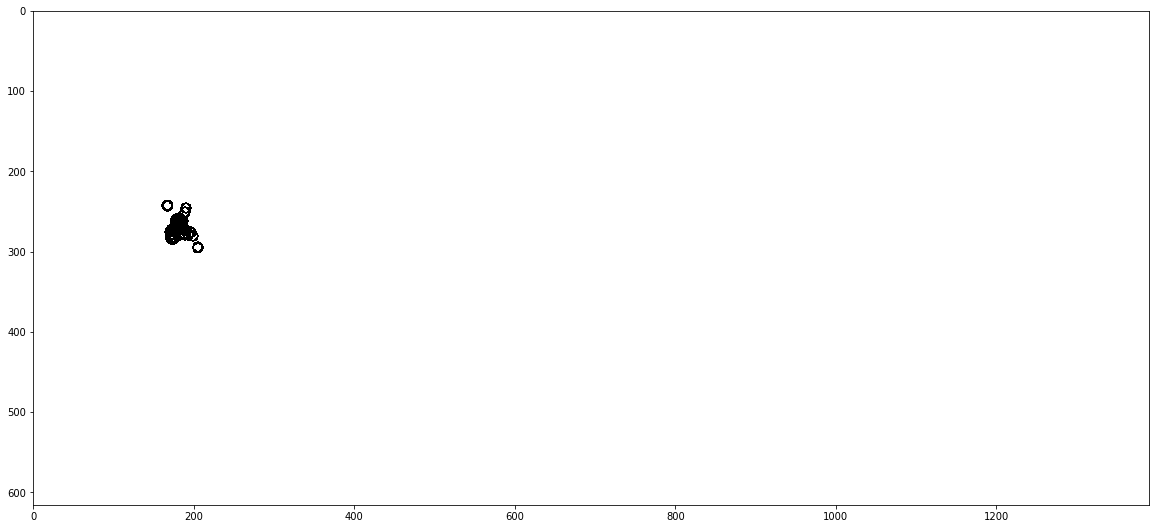

[[167, 243], [190, 246], [189, 251], [182, 259], [178, 260], [182, 261], [186, 262], [180, 263], [178, 264], [179, 264], [180, 265], [181, 265], [184, 265], [185, 265], [178, 266], [179, 266], [180, 266], [181, 266], [182, 266], [179, 267], [180, 267], [179, 268], [182, 268], [183, 268], [177, 269], [178, 269], [179, 269], [186, 269], [176, 270], [177, 270], [179, 270], [180, 270], [181, 270], [185, 270], [177, 271], [178, 271], [173, 272], [179, 272], [180, 272], [175, 273], [173, 275], [179, 275], [170, 276], [176, 276], [196, 276], [172, 279], [183, 279], [189, 279], [193, 279], [199, 281], [172, 284], [175, 284], [205, 295]]
To be removed
[]
To be removed
[]
There is 1 Barycenter:
[[181, 269]]


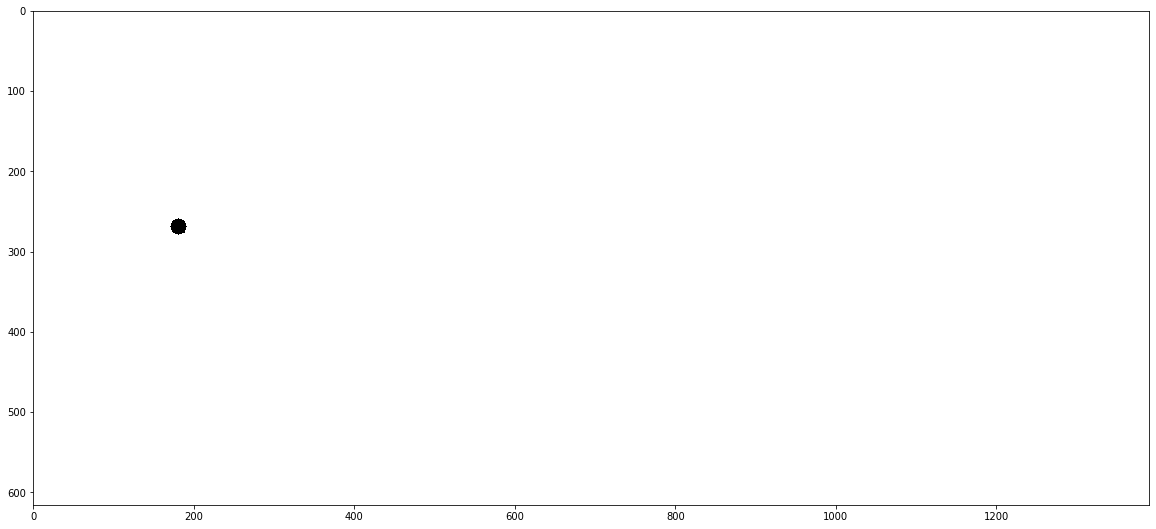

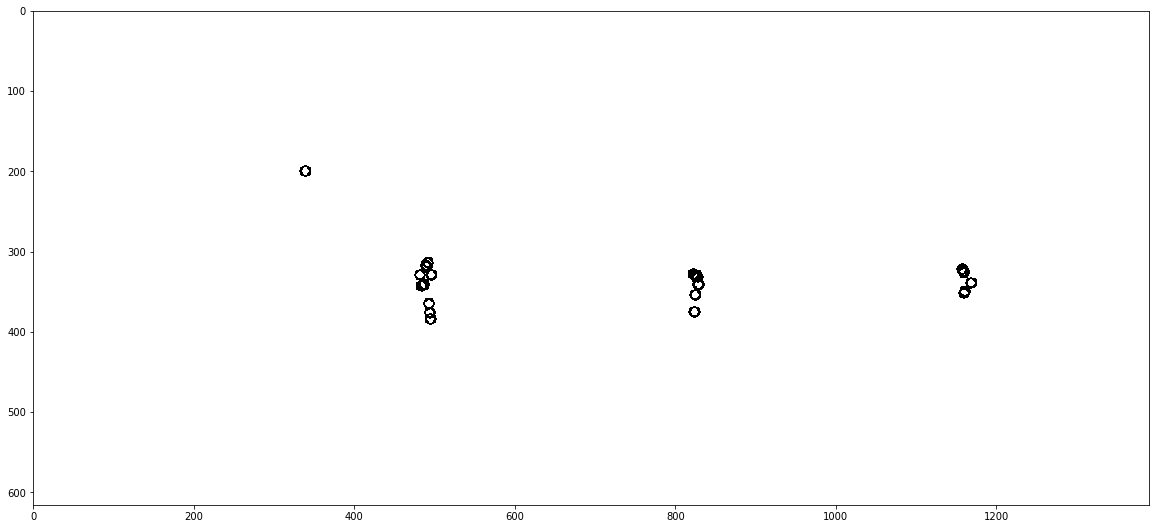

[[339, 200], [492, 314], [489, 317], [489, 318], [490, 319], [1158, 322], [1160, 325], [1160, 326], [823, 328], [482, 329], [496, 329], [825, 329], [827, 330], [826, 331], [828, 332], [1169, 339], [487, 341], [829, 341], [485, 342], [484, 343], [1161, 350], [1160, 352], [825, 354], [493, 365], [824, 375], [494, 376], [495, 384]]
To be removed
[]
To be removed
[[339, 200]]
There are 3 Barycenters:
[[490, 340], [1161, 336], [826, 340]]


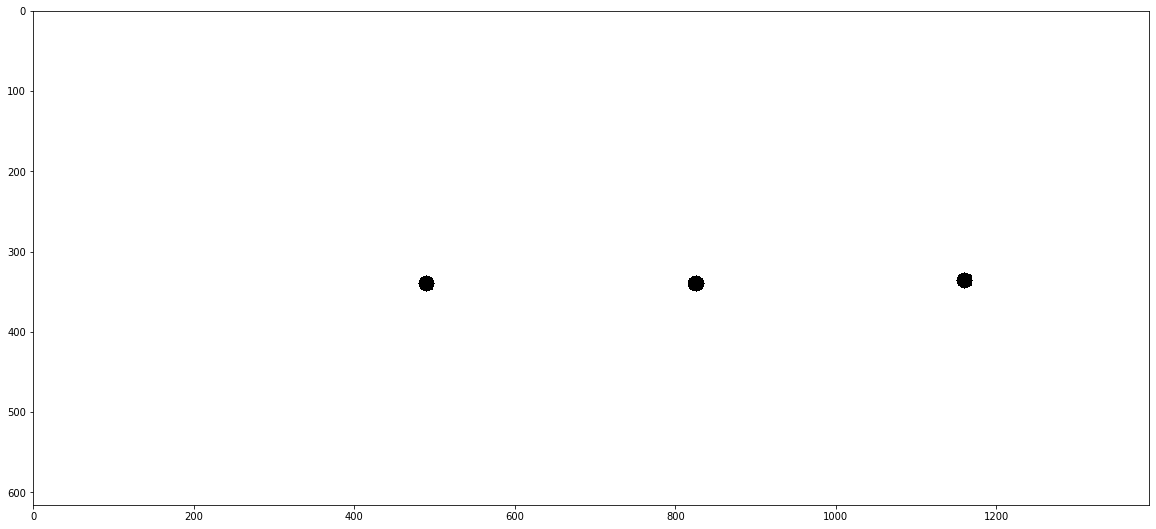

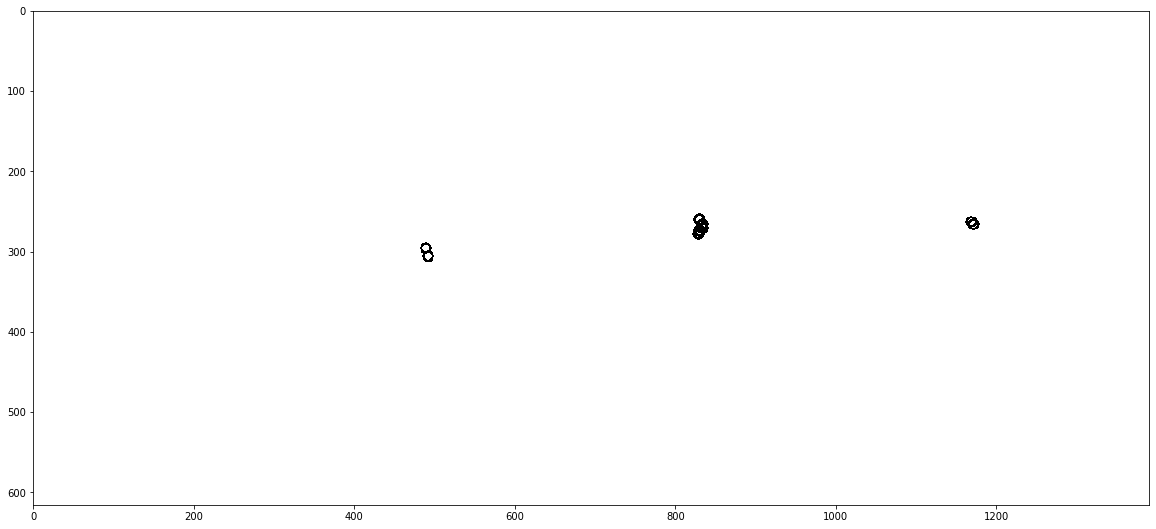

[[830, 260], [1169, 263], [834, 266], [1172, 266], [834, 271], [830, 274], [829, 278], [489, 296], [492, 306]]
To be removed
[]
To be removed
[[1170, 264], [490, 301]]
There is 1 Barycenter:
[[831, 270]]


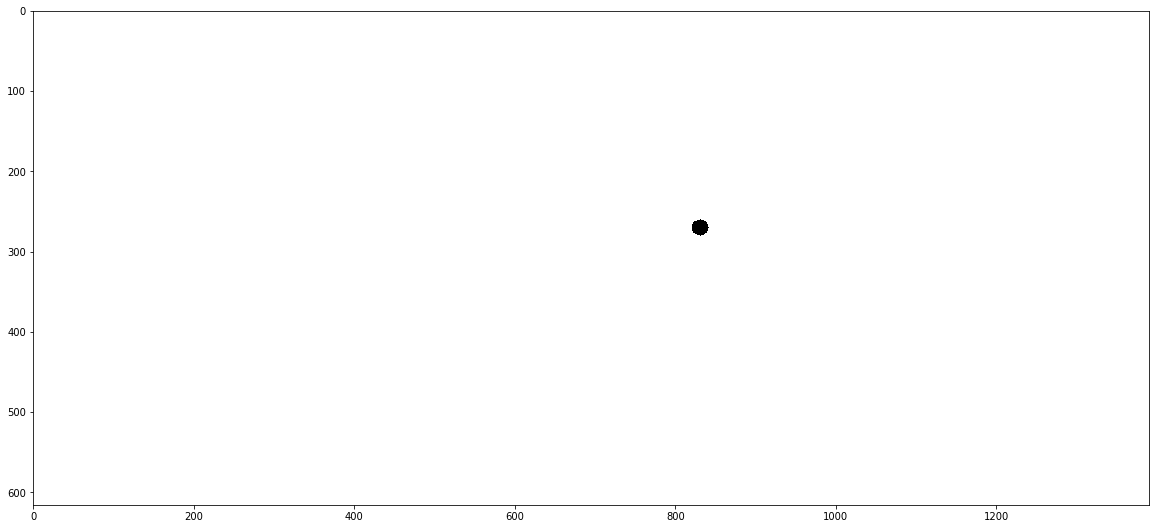

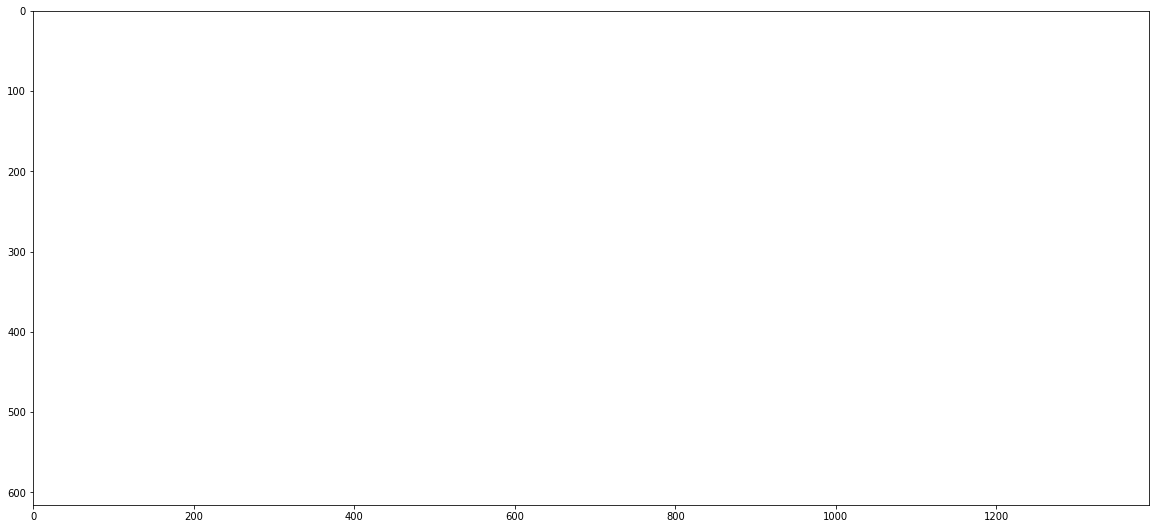

[]
To be removed
[]
To be removed
[]
There is no Barycenter


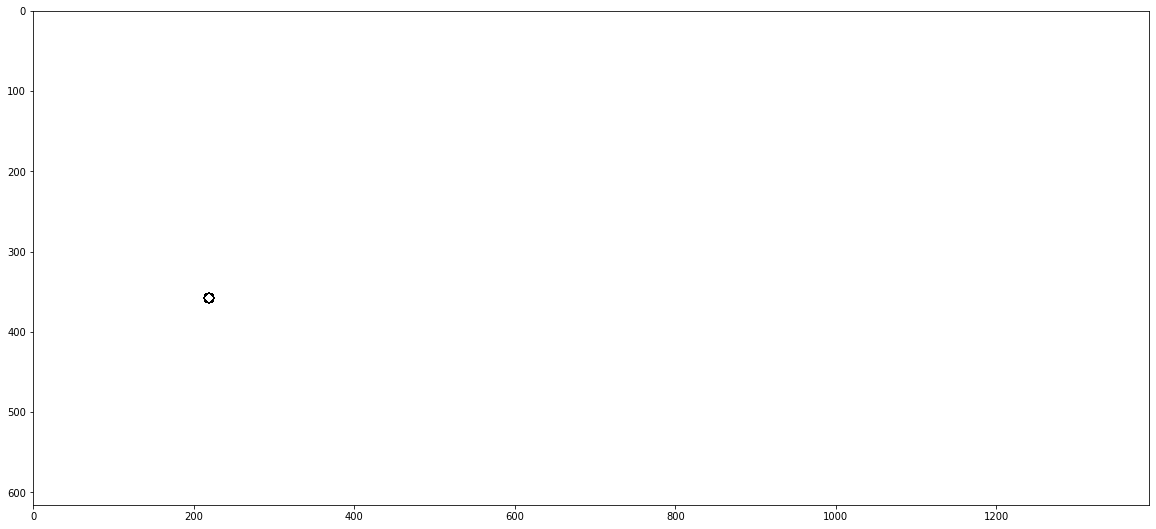

[[219, 358]]
To be removed
[]
To be removed
[]
There is no Barycenter


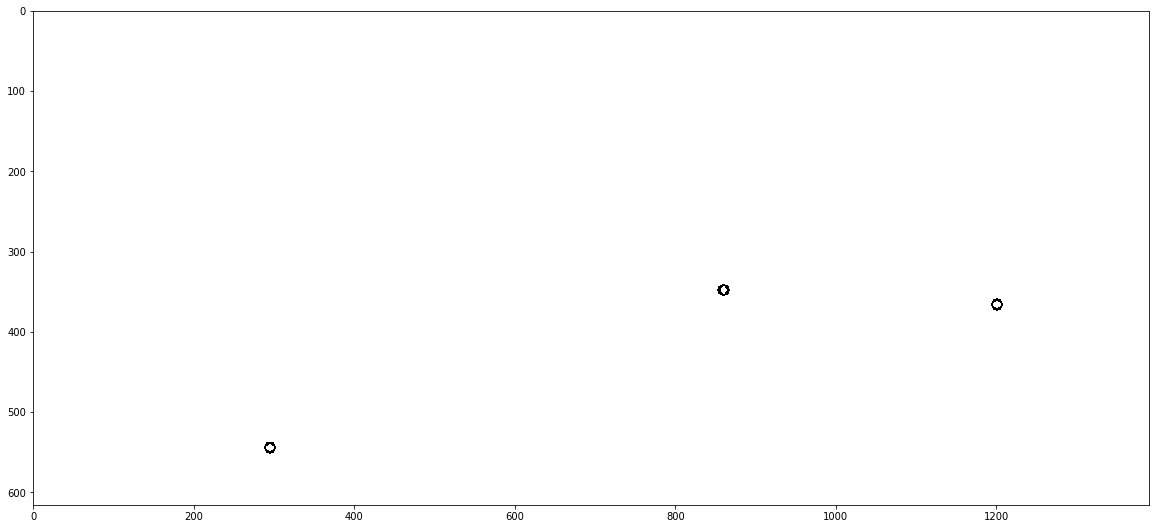

[[860, 348], [861, 348], [1201, 366], [295, 544]]
To be removed
[]
To be removed
[[860, 348], [1201, 366]]
There is no Barycenter


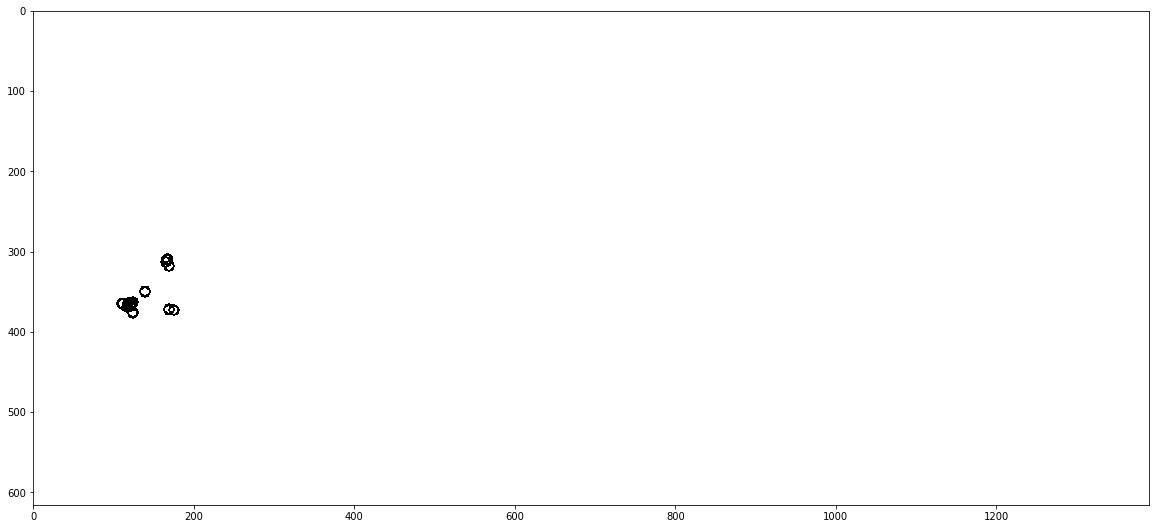

[[167, 310], [165, 313], [169, 318], [139, 350], [124, 363], [118, 364], [111, 365], [122, 365], [121, 368], [117, 369], [169, 372], [175, 373], [124, 376]]
To be removed
[]
To be removed
[]
There is 1 Barycenter:
[[140, 354]]


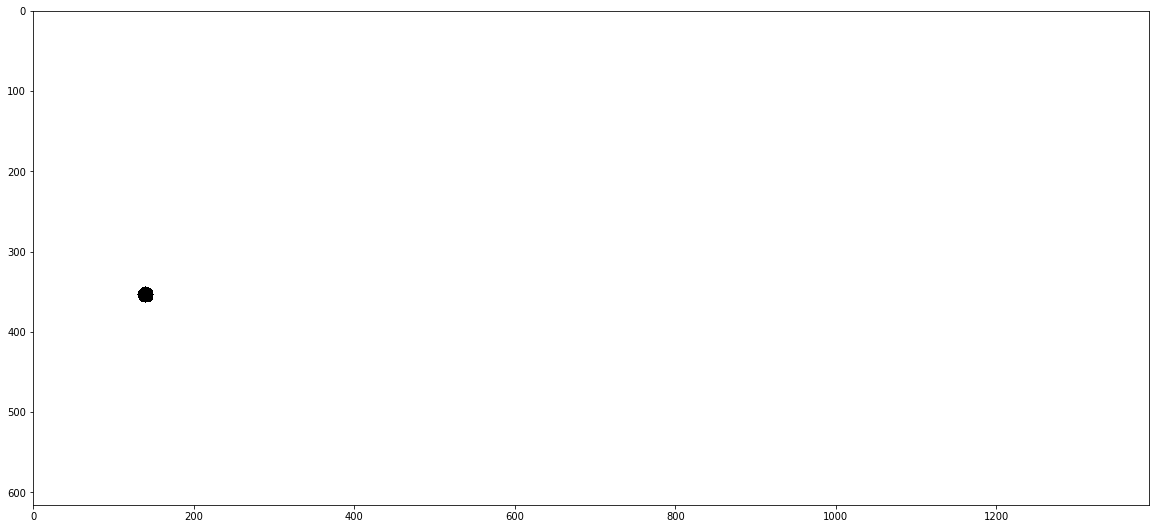

[181, 269]
step1
step2
step3
step4
[490, 340]
step1
step2
step3
[1161, 336]
step1
step2
step3
step4
[826, 340]
step1
step2
step3
step4
[831, 270]
step1
step2
step3
[140, 354]
step1
Scene m2:


Product 0 - 1 instances found:

	Instance 1: {position: (179,300), width: 348px, heigh: 453px}

Product 1 - 2 instances found:

	Instance 1: {position: (1180,285), width: 296px, heigh: 416px}
	Instance 2: {position: (848,287), width: 314px, heigh: 415px}


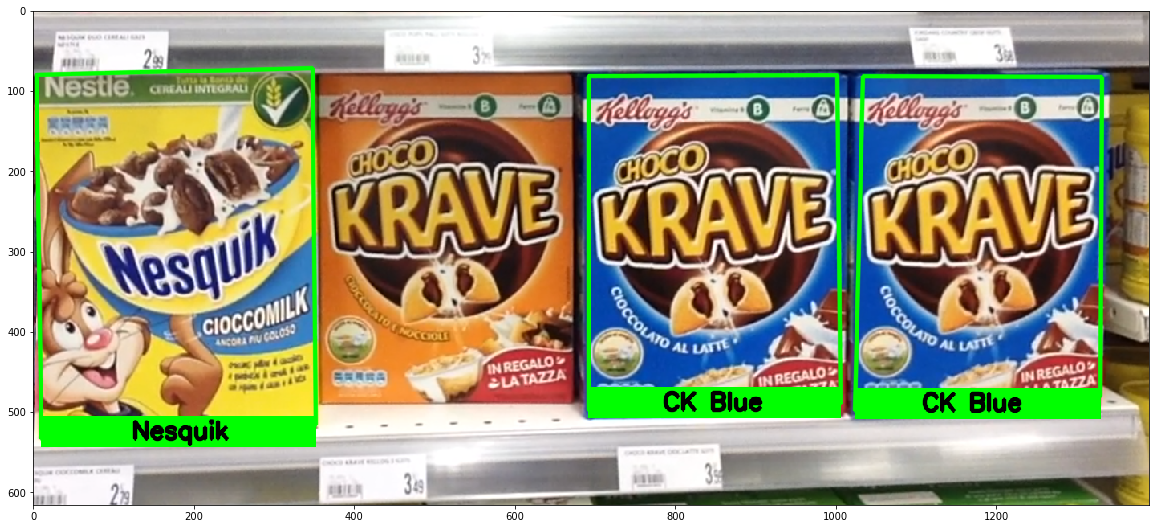

In [25]:
for i in range(len(scenes)):
        #creo una copia della scena da modificare
        copy_scene = np.copy(scenes[i])
        kp_scene = sift.detect(grey_scenes[i])
        kp_scene, des_scene = sift.compute(grey_scenes[i], kp_scene)
        barycenters_list, final_good = generalizedHoughTransform(grey_scenes[i], images)
        per_check = searchTemplates(images, copy_scene, barycenters_list, final_good, LIMIT_INC)
        drawResults(copy_scene, per_check, scenes_names[i])